# Packages

In [35]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
torch.set_default_tensor_type('torch.DoubleTensor')

# NN Model

In [36]:
class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(12, 25)
        self.fc2 = nn.Linear(25, 30)
        self.fc3 = nn.Linear(30, 15)
        self.fc4 = nn.Linear(15, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

In [37]:
def read_weight(filename):
    model_weight = torch.load(filename)
    model = Network()
    model.load_state_dict(model_weight)
    return model

# Drone

**Dynamics**
$$m\ddot{z} = -mg + u + f_a(z,\dot{z}),\quad 0 \leq u \leq 1.7mg$$

In [75]:
class Drone:

    def __init__(self, init_z=1.5, init_v=0, C=1.0, h_d=0.0, delay=0.2, sim_duration=10, theta=None, oracle=False, open_loop=False):
        # Drone parameters
        self.mass = 1.47                  # mass
        self.g = 9.81                     # gravity
        self.drone_height = 0.09          # drone's self-height
        self.delay = delay                # control delay, 0 if there is no delay
        self.thrust_max = 1.7             # control constrain, 0 <= u <= 1.7mg
        
        # NN model for unknown dynamics
        self.Fa_model = read_weight('Fa_net_12_3_full_Lip16.pth')

        # Control parameters
        self.gain = 1.0
        self.oracle = oracle

        # Desired trajectory parameters
        self.C = C                        # how fast to land
        self.h_d = h_d                    # desired landing height 
        
        # Real states
        self.init_z = init_z
        self.z = init_z                   # height
        self.v = init_v                   # velocity
        self.a = 0                        # acceleration
        self.u_d = 0                      # desired control signal
        self.u = 0                        # control signal              
        self.prev_u = 6508                # previous control signal
        self.Fa = 0                       # observed Fa
        self.Fa_nn = 0                    # Fa directly from the NN model

        # Noise
        self.a_noise_sigma = 0.1
        self.u_noise_sigma = 0
        self.a_noise = 0
        self.u_noise = 0

        # Step
        self.step_size = 1e-2
        self.total_step = 0 
        self.sim_duration = sim_duration

        # Misc.
        self.open_loop = open_loop
        if self.open_loop:
            self.y = self.schroeder_sweep()
        self.theta = theta

    def schroeder_sweep(self):
        def get_phi(p, N, phi1 = -np.pi/2):
            phi = [phi1]
            for i in range(len(p)):
                if i == 0:
                    continue
                gt = phi1 - 2*np.pi*(i+1)*sum(p[:i]) + 2*np.pi*sum([j*p[j] for j in range(i)])
                phi.append(gt)
            return phi

        def get_r(t, p, N, T, phi1=-np.pi/2, k=1):
            phi = get_phi(p, N)
            rs = [0 for _ in range(k)]
            for i in range(N):
                rs[i % k] += np.sqrt(p[i]/2) * np.cos(2*np.pi*i*t/T + phi[i]) + 0.5
            return rs[0] if k == 1 else rs

        N = 40
        p = [1/N for i in range(N)] # flat power spectra
        p = [(1/8)*np.sin(np.pi*(2*i - 1)/32)**2 for i in range(N)] # not-flat power spectra
        T = 10
        ts = np.array([i*self.step_size for i in range(int(np.ceil(self.sim_duration/self.step_size)))])
        k = 1
        y = [get_r(t, p, N, T) for t in ts]
        return y
        
    def noise(self):
        # Noise freq is 10
        if not self.total_step % int(1 / self.step_size * 0.1): 
            self.a_noise = np.random.normal(0, self.a_noise_sigma)
            if self.a_noise > 3 * self.a_noise_sigma:
                self.a_noise = 3 * self.a_noise_sigma
            if self.a_noise < -3 * self.a_noise_sigma:
                self.a_noise = -3 * self.a_noise_sigma

            self.u_noise = np.random.normal(0, self.u_noise_sigma)
            if self.u_noise > 3 * self.u_noise_sigma:
                self.u_noise = 3 * self.u_noise_sigma
            if self.u_noise < -3 * self.u_noise_sigma:
                self.u_noise = -3 * self.u_noise_sigma
                
    def baseline_controller(self):
        t = self.step_size * self.total_step
        z_d = np.exp(-self.C*t) * (1+self.C*t) * (self.init_z-self.h_d) + self.h_d
        z_dot_d = np.exp(-self.C*t) * (-self.C**2*t) * (self.init_z-self.h_d)
        z_ddot_d = np.exp(-self.C*t) * (self.C**3*t-self.C**2)

        # Here mean is the mean of Fa_hat
        mean = 0
        if self.oracle:
            mean = self.Fa_nn

        self.u_d = self.mass * (self.g + z_ddot_d - 2*self.gain*(self.v-z_dot_d) - self.gain**2*(self.z-z_d)) - mean
        
        # Consider control delay
        u = (1-self.delay) * self.prev_u + self.delay * self.u_d 
        
        # Control constrain
        if u > self.thrust_max*self.mass*self.g:
            u = self.thrust_max*self.mass*self.g
        if u < 0:
            u = 0

        # Control noise
        u = u + self.u_noise

        self.u = u
        self.prev_u = u

    def open_loop_controller(self):
        u = self.y[self.total_step]
        self.u = u

    def MPC(self):
        pass
        
    def dynamics(self):
        # use prediction from NN as ground truth
        state = np.zeros([1,12])
        state[0,0] = self.z + self.drone_height
        state[0,3] = self.v
        state[0,7] = 1.0
        state[0,8:12] = 6508.0/8000
        state_torch = torch.from_numpy(state)
        Fa = self.Fa_model(state_torch)[0, 2].item()
        self.a = self.u/self.mass - self.g + self.a_noise + Fa/self.mass
        self.Fa_nn = Fa

    # ODE solver: Euler
    def process(self):
        self.noise()
        if self.theta is not None:
            self.MPC()
        elif self.open_loop:
            self.open_loop_controller()
        else:
            self.baseline_controller()
        self.dynamics()
        
        self.z = self.z + self.step_size * self.v
        self.v = self.v + self.step_size * self.a
                
        self.Fa = self.mass * (self.a + self.g) - self.u
        self.total_step += 1

    def simulate(self):
        Height = []
        Height = np.append(Height, self.z)
        Velocity = []
        Velocity = np.append(Velocity, self.v)
        Control = []
        Acceleration = []
        Fa = []
        Fa_nn = []

        while True:
            self.process()
            Height = np.append(Height, self.z)
            Velocity = np.append(Velocity, self.v)
            Control = np.append(Control, self.u)
            Acceleration = np.append(Acceleration, self.a)
            Fa = np.append(Fa, self.Fa)
            Fa_nn = np.append(Fa_nn, self.Fa_nn)

            if not self.total_step % int(1 / self.step_size):
                print('Simulation time: ' + str(self.total_step*self.step_size))

            if self.step_size*self.total_step >= self.sim_duration:
                break

        return Height, Velocity, Control, Acceleration, Fa, Fa_nn

# Simulation

In [96]:
def sim(drone):
    Height, Velocity, Control, Acceleration, Fa, Fa_nn = drone.simulate()
    time = np.linspace(drone.step_size, drone.sim_duration, len(Height[:-1]))

    
    plt.figure(figsize=(12,7))
    plt.subplot(2, 3, 1)
    plt.plot(time[:], Height[:-1])
    plt.xlabel("time [s]")
    plt.ylabel("height [m]")
    plt.title("height")
    plt.hlines(y=0, xmin=drone.step_size, xmax=drone.sim_duration, color='r', linestyles='--')

    plt.subplot(2, 3, 2)
    plt.plot(time[:], Velocity[:-1])
    plt.xlabel("time [s]")
    plt.ylabel("velocity [m/s]")
    plt.title("velocity")
    plt.hlines(y=0, xmin=drone.step_size, xmax=drone.sim_duration, color='r', linestyles='--')

    plt.subplot(2, 3, 3)
    plt.plot(time[:], Control)
    plt.xlabel("time [s]")
    plt.ylabel("control [rps]")
    plt.title("control")

    plt.subplot(2, 3, 4)
    plt.plot(Velocity[:-1], Height[:-1])
    plt.xlabel("velocity [m/s]")
    plt.ylabel("height [m]")
    plt.title("velocity v.s. height")

    plt.subplot(2, 3, 5)
    plt.plot(time[:], Fa)
    plt.xlabel("time [s]")
    plt.ylabel("Fa [N]")
    plt.title("Fa")
    
    plt.subplot(2, 3, 6)
    plt.plot(time[:], Fa_nn)
    plt.xlabel("time [N]")
    plt.ylabel("Fa_nn [N]")
    plt.title("Fa_nn")
    
    plt.tight_layout()
    plt.show()
    return Height, Velocity, Control, Acceleration, Fa, Fa_nn

Simulation time: 1.0
Simulation time: 2.0
Simulation time: 3.0
Simulation time: 4.0
Simulation time: 5.0
Simulation time: 6.0
Simulation time: 7.0
Simulation time: 8.0
Simulation time: 9.0
Simulation time: 10.0


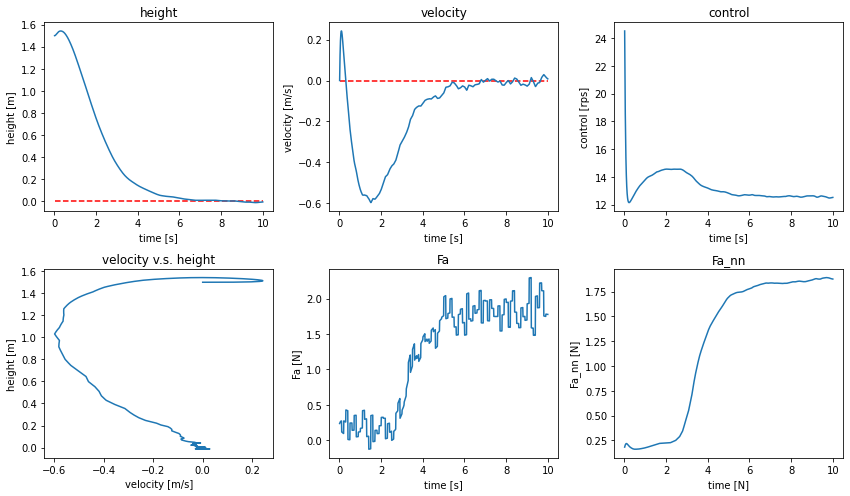

In [97]:
drone = Drone(oracle=True, open_loop=False)
z, v, u, a, fa, fa_nn = sim(drone)

Simulation time: 1.0
Simulation time: 2.0
Simulation time: 3.0
Simulation time: 4.0
Simulation time: 5.0
Simulation time: 6.0
Simulation time: 7.0
Simulation time: 8.0
Simulation time: 9.0
Simulation time: 10.0


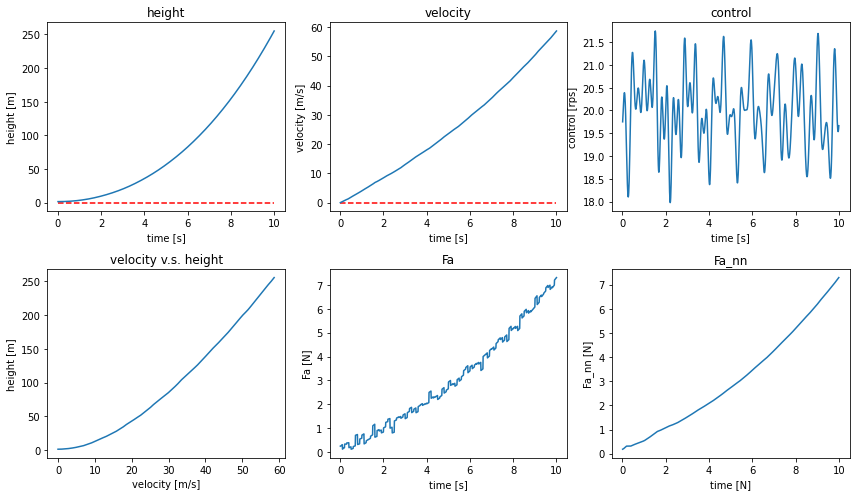

In [40]:
drone1 = Drone(oracle=True, open_loop=True)
z1, v1, u1, a1, fa1, fa_nn1 = sim(drone1)

In [41]:
import pickle

with open('sindy_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [101]:
model.feature_names
model.get_feature_names()
model.coefficients().shape

1000

In [43]:
import numpy as np

class state:
    """
    Convert true state into SINDy state
    """
    def __init__(self, features, feature_names):
        self.features = features
        self.feature_names = feature_names

    def get_state(self, vals):
        for i, feature in enumerate(self.features):
            locals()[feature] = vals[i]
        s = []
        for feature in self.feature_names:
            exp = feature.replace(" ", "*").replace("^", "**").replace("sin", "np.sin").replace("cos", "np.cos")
            s.append(eval(exp))
        return np.array(s)

In [50]:
s = state(model.feature_names, model.get_feature_names())
A = model.coefficients()


In [57]:
def sample_sphere(d, N=20):
    # Sample N random vectors on d dimensional sphere where d is the dimension of the parameter space (in this case it is 2x28 = 56)
    # returns N samples of d-dimensional vectors where x is N by d
    
    x = np.random.normal(size=(N, d))
    x /= np.linalg.norm(x, axis=1)[:, np.newaxis]
    return x

def support(Z, nx, n_phi, sindyState_list, state_list, lb, ub, W=1.0):
    # Given a set of N random vectors cancatenated as Z (N by d), compute the support function evaluated at each of the random vector

    d = nx * n_phi
    Y = np.zeros((Z.shape[0], d))
    y = cp.Variable((n_phi,nx)) # defining in this way because when we take cp.vec(y), y is flattened in column-major order. y = transpose(A)
    constraints = [cp.vec(y) <= ub*np.ones((d,1))] # box constraints
    constraints += [cp.vec(y) >= lb*np.ones((d,1))] # box constraints
    for (next_x, phi) in zip(state_list[1:], sindyState_list):
        constraints += [next_x.reshape((nx,1)) - y.T @ phi <= W*np.ones((nx,1))]
        constraints += [next_x.reshape((nx,1)) - y.T @ phi >= -W*np.ones((nx,1))]

    for i, zi in enumerate(Z):
        prob = cp.Problem(cp.Minimize(zi.transpose()@ cp.vec(y)), constraints)
        prob.solve()
        Y[i] = y.value.flatten(order='F') # make numpy flatten in column-major order to match the pattern of y
    return Y

def get_parameter(sindyState_list, state_list, nx, n_phi, lb, ub, W=1.0):
    # algorithm taken from https://arxiv.org/pdf/1905.11877.pdf Algorithm 3.
    # sindyState_list: list of sindy states (vector of nonlinear function eval at x(t),u(t)) indexed from t=1 to T-1
    # state_list: list of actual states (vectors of x(t)) indexed from t=1 to T
    # W,lb,ub: disturbance bound, lower and upper bound on the parameter space.
    
    d = nx*n_phi  # d: dimension of the parameter space
    Z = sample_sphere(d) # Z is a N by d matrix with N iid sampled R^d unit vector on the unit sphere
    P = support(Z, nx, n_phi, sindyState_list, state_list, lb, ub, W) # P is a N by nx*n_phi matrix with N sampled points in the polytope
    theta =  np.mean(P,0) # summing over all rows and divide by number of cols to get a row vector of size nx*n_phi.
    A = theta.reshape((nx, n_phi))
    return A, A.reshape((d,))



def still_consistent(theta, nx, n_phi, sindyState_list, state_list):
    eps = 1e-6
    consistency = False
    A = theta.reshape((nx, n_phi))
    violation = 0
    for (next_x, phi) in zip(state_list[1:], sindyState_list):
        violation += (not(next_x.reshape((nx,1)) - y.T @ phi <= (W+eps) *np.ones((nx,1)))) + (not(next_x.reshape((nx,1)) - y.T @ phi >= -(W+eps)*np.ones((nx,1))))
        
    if violation == 0:
        consistency = True
    
    return consistency


def CBC(Height, Velocity, Control, theta_curr, W=1.0):
    '''
    Takes in the trajectory of SINDy states and output the selected consistent A matrix (here it is 2x28)
    Assuming x0 = z, x1 = z_dot
    W is a tunable parameter representing the l-inf bound on the unaccounted dynamics such as discretization error
    '''
    
    # First we convert the entire trajectory of the z, z_dot, and u into SINDy state trajectory
    sindyState_list = [] # list of SINDy states where each element in the list is a tuple of 28 items
    state_list = [] # list of [z, z_dot]
    
    # TODO: check list length of Height, Velocity and Control. Control should be 1 less than the other two.
    for (z, z_dot, u) in zip(Height, Velocity, Control):
        # s here is the SINDy state converter
        sindyState_list = np.append(s_list, s.get_state((z, z_dot, u)))
        state_list = np.append(state_list, np.array([z, z_dot]))
    state_list = np.append(state_list, np.array([Height[-1], Velocity[-1]])) # catching the last transition without control

    
    # check if the previous theta is still consistent, change if not.
    if still_consistent(theta_curr, sindyState_list, state_list):
        theta_t = theta_curr
    else:
        A_t, theta_t = get_parameter(sindyState_list, state_list, nx, n_phi, lb, ub, W=1.0)
        
    
    
    return theta_t

In [46]:
def meta_controller(init_theta, simulator, t_controller, t_meta, init_z=1.5, init_v=0):
    z_curr = init_z
    v_curr = init_v
    theta_curr = init_theta
    Height, Velocity, Control, Acceleration, Fa, Fa_nn = [], [], [], [], [], []
    for i in range(t_meta):
        drone = Drone(init_z=z_curr, init_v=v_curr, sim_duration=t_controller, theta=theta_curr)
        z, v, u, a, fa, fa_nn = sim(drone)
        Height += z
        Velocity += v
        Control += u
        Acceleration += a
        Fa += fa
        Fa_nn += fa_nn
        z_curr = Height[-1]
        v_curr = Velocity[-1]
        theta_curr = CBC(Height, Velocity, Control, theta_curr)
        
        # I assume you are going to use theta in somewhere here before you return the trajectory?
        
    return Height, Velocity, Control, Acceleration, Fa, Fa_nn

In [107]:
A = np.array([1,2,3,4,5,6]).reshape((2,3))
B = A.reshape((3,2))

In [108]:
A

array([[1, 2, 3],
       [4, 5, 6]])

In [123]:
v= (not(0>=2)) + (not(3<2))
v

2

In [124]:
1e-6

1e-06